In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import numpy
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


def read_in_data():
    """
    Reads in our collected BTC csv into a pandas data frame and removes all other columns other than the close price
    
    :param - 
    :returns - Pandas data frame containing the close price indexed by time
    """
    
    data_frame = pd.DataFrame()
    file = "tweets_with_BTC_prices.csv"
    data_frame = pd.read_csv(file, names=["Date", "time", "open", "high", "low", "close", "volume", "adj_close", "tweets"])
    data_frame.set_index("Date", inplace = True)
    data_frame = data_frame[["close"]]     
    return data_frame

In [2]:
def normalize_data(scaler, close_list):
    """
    This section takes in our value lists and scales them using a minmaxscaler within the range 0,1 and reshapes our data.
    We then seperate our data into training and testing sets to a 80:20 split to be used to train and evaluate our model
    
    :param - scaler, close_list
    :returns - train, test
    """
    
    close_list = scaler.fit_transform(np.array(close_list).reshape(-1,1))
    
    train_split = int(len(close_list)*0.80)    
    train = close_list[0:train_split]
    test = close_list[train_split:len(close_list)]
    
    return train, test

In [3]:
def create_train_test_set(data, lookahead):
    """
    This method takes in either our train or test set and creates a time lag of the predefined lookahead value
    It then returns the X and Y list where Y contains the time lagged data

    :param - data, lookahead
    :returns - X_train, X_test, y_train, y_test
    """
    
    X = list()
    Y = list()
        
    length = len(data)    
    for i in range(length-lookahead-1):
        X.append(data[i:(i+lookahead)])
        Y.append(data[i + lookahead])
    return numpy.array(X), numpy.array(Y)
    

In [4]:
def create_lstm_model():
    """
    This method defines the general structure for the regressor that is passed into grid search
    
    :param - 
    :returns - model
    """
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(7,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    
    return model



In [5]:
def forecast_model(df, model, scaler,close_list, X_train, y_train):
    """
    In this method we forecast using our model and the test data set
    We then plot the inverse scaled values onto a graph with the real BTC price
    
    :param - X_train, y_train, X_test, y_test
    :returns - model
    """
    
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    
    forecast_movement = np.concatenate((train_predict,test_predict))
    real_movement = df[["close"]][:288].values

    plt.figure(figsize=(16,8))
    plt.plot(real_movement, color = 'green', label = 'Real Prices')
    plt.plot(forecast_movement,  color = 'purple', label = 'Predicted Prices')
    plt.xlabel('Trades')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.show()


In [6]:
#Defining our scaler and lookahead values
scaler = MinMaxScaler(feature_range=(0,1))
lookahead = 7
df = read_in_data()
df = df.iloc[1: , :]
df['close'] = df['close'].astype(float)

close_list = df.reset_index()['close']


In [7]:
train, test = normalize_data(scaler, close_list)
X_train, y_train = create_train_test_set(train, lookahead)
X_test, y_test = create_train_test_set(test, lookahead)

X_train= X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)



In [8]:
model = create_lstm_model()

In [9]:
model.load_weights("Saved_model_lstm/cp.ckpt")

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 7, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


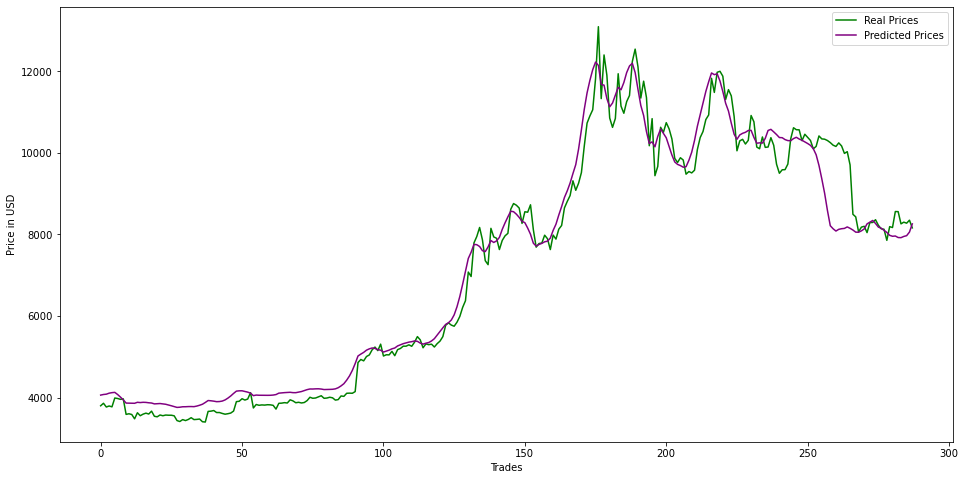

In [11]:
forecast_model(df, model, scaler, close_list, X_train, y_train)

In [5]:
import sklearn.metrics
import math
actual = [38308.13000000,38386.89000000,40079.17000000,43845.92241000,40515.70000000]
predicted = [42616.5859375, 41949.75, 41372.6640625, 40425.3203125, 39662.33984375]

mse = sklearn.metrics.mean_squared_error(actual, predicted)

rmse = math.sqrt(mse)

print(rmse)

3011.9307130277152


In [4]:
import pandas as pd
today = pd.to_datetime("today").normalize()
print(today)

2022-03-02 00:00:00


In [2]:
from binance import *
from binance import exceptions

#async def get_current_user_client(token: str = Depends(oauth2_scheme)):
 #   user = fake_decode_token(token)
    #return clients[user]
    
client = Client("nxOzvBKAdAQKS0Lt2BP6595pddj7r3IfgchMm6o1iGy5AeI3xzlqU6Qp1IVjGM7c",
                "x0zRncgRRJlTcS6Gi7Oh5CjCisuYQAHOr7xaxV2ZgoSCn0cwKb4pGeIWjr390kvp", testnet=True)

In [ ]:
try:
    order = client.order_limit_buy(
        symbol="USDT",
        quantity=quantity,
        price=price)
except exceptions.BinanceAPIException as e:
    print(e.message)